In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from kfold import two_fold_split, three_fold_split, four_fold_split, five_fold_split
from normalizers import StandardScaler
from metrics import MSE, RMSE
from LR_Model import LinearRegression
from utils import plot_RMSEs, EarlyStopping

In [2]:
df_data = pd.read_csv('Real estate.csv', index_col=0)

In [3]:
df_data

,X1 transaction date,X2 house age,X3 distance to the nearest MRT station,X4 number of convenience stores,X5 latitude,X6 longitude,Y house price of unit area
No,,,,,,,
1,2012.917,32.0,84.87882,10,24.98298,121.54024,37.9
2,2012.917,19.5,306.59470,9,24.98034,121.53951,42.2
3,2013.583,13.3,561.98450,5,24.98746,121.54391,47.3
4,2013.500,13.3,561.98450,5,24.98746,121.54391,54.8
5,2012.833,5.0,390.56840,5,24.97937,121.54245,43.1
...,...,...,...,...,...,...,...
410,2013.000,13.7,4082.01500,0,24.94155,121.50381,15.4
411,2012.667,5.6,90.45606,9,24.97433,121.54310,50.0
412,2013.250,18.8,390.96960,7,24.97923,121.53986,40.6


In [4]:
df_data['Years since'] = df_data['X1 transaction date'].apply(lambda x: 2018 - int(str(x).split('.')[0]))

In [5]:
df_data

,X1 transaction date,X2 house age,X3 distance to the nearest MRT station,X4 number of convenience stores,X5 latitude,X6 longitude,Y house price of unit area,Years since
No,,,,,,,,
1,2012.917,32.0,84.87882,10,24.98298,121.54024,37.9,6
2,2012.917,19.5,306.59470,9,24.98034,121.53951,42.2,6
3,2013.583,13.3,561.98450,5,24.98746,121.54391,47.3,5
4,2013.500,13.3,561.98450,5,24.98746,121.54391,54.8,5
5,2012.833,5.0,390.56840,5,24.97937,121.54245,43.1,6
...,...,...,...,...,...,...,...,...
410,2013.000,13.7,4082.01500,0,24.94155,121.50381,15.4,5
411,2012.667,5.6,90.45606,9,24.97433,121.54310,50.0,6
412,2013.250,18.8,390.96960,7,24.97923,121.53986,40.6,5


In [6]:
X = df_data.drop(columns=['Y house price of unit area', 'X1 transaction date'])
y = df_data['Y house price of unit area']

In [7]:
two_folds = two_fold_split(X, y)
three_folds = three_fold_split(X, y)
four_folds = four_fold_split(X, y)
five_folds = five_fold_split(X, y)

In [8]:
def add_ones(X):
    return np.concatenate((np.ones((X.shape[0], 1)), X), axis=1)

In [9]:
def solveNormalEquation(X, y):
    """
    Implementation of a function to solve the normal equation

    Args:
        X: Data to solve
        y: Labels to solve

    Returns:
        The solution to the normal equation
    """
    # X = add_ones(X)
    params = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)
    return params

In [10]:
def evaluate_model(X, y, params):
    """
    Implementation of a function to evaluate the model

    Args:
        X: Data to evaluate
        y: Labels to evaluate
        params: Parameters of the model

    Returns:
        The evaluation of the model
    """
    y_pred = X.dot(params)
    return RMSE(y, y_pred), MSE(y, y_pred)

# Gradient Descent

In [11]:
learning_rates = [0.0001, 0.001, 0.01, 0.1, 1, 10]

K = 2

In [12]:
for learning_rate in learning_rates:
    valRMSEs = []
    valMSEs = []
    trainRMSEs = []
    trainMSEs = []
    print(f'Learning Rate: {learning_rate}')
    for fold in two_folds:
        X_train, y_train, X_test, y_test = fold

        standard_scaler = StandardScaler()
        X_train = standard_scaler.fit_transform(X_train)
        X_test = standard_scaler.transform(X_test) 

        X_train = add_ones(X_train)
        X_test = add_ones(X_test)

        LR = LinearRegression(learning_rate=learning_rate, epochs=1000, early_stopping=True)
        LR.fit(X_train, y_train)
        params = LR.get_params()

        rmse_val, mse_val = evaluate_model(X_test, y_test, params)

        valRMSEs.append(rmse_val)
        valMSEs.append(mse_val)

        rmse_train, mse_train = evaluate_model(X_train, y_train, params)
        trainMSEs.append(mse_train)
        trainRMSEs.append(rmse_train)
        print(f"Validation RMSE: {rmse_val}, Validation MSE: {mse_val}")
        # print(f"Training RMSE: {rmse_train}, Training MSE: {mse_train}")
    print(f"For Validation - Average RMSE: {np.mean(valRMSEs)}, RMSE Variance: {np.var(valRMSEs)}")
    # print(f"For Validation - Average MSE: {np.mean(mse_val)}, MSE Variance: {np.var(mse_val)}")
    print(f"For Training - Average RMSE: {np.mean(trainRMSEs)}, RMSE Variance: {np.var(trainRMSEs)}")
    # print(f"For Training - Average MSE: {np.mean(mse_train)}, MSE Variance: {np.var(mse_train)}")
    print()

Learning Rate: 0.0001
Validation RMSE: 36.214587773310285, Validation MSE: 1311.496367590795
Validation RMSE: 35.816254490787934, Validation MSE: 1282.804085748887
For Validation - Average RMSE: 36.01542113204911, RMSE Variance: 0.039667350991257844
For Training - Average RMSE: 36.006943388218325, RMSE Variance: 0.008231790478827305

Learning Rate: 0.001
Validation RMSE: 16.640112872492434, Validation MSE: 276.89335640928846
Validation RMSE: 16.462243939582923, Validation MSE: 271.0054755263347
For Validation - Average RMSE: 16.55117840603768, RMSE Variance: 0.007909339323592082
For Training - Average RMSE: 16.485028188659257, RMSE Variance: 0.09449232445420529

Learning Rate: 0.01
Validation RMSE: 8.165105652285218, Validation MSE: 66.66895031298003
Validation RMSE: 9.629049634769604, Validation MSE: 92.71859686885664
For Validation - Average RMSE: 8.89707764352741, RMSE Variance: 0.5357829959630609
For Training - Average RMSE: 8.730389008224652, RMSE Variance: 0.5452806822784588

Lea

## As we can see a LR of 0.1 performs the best so we'll plot that and have a look

In [13]:
all_trainRMSEs = []
all_valRMSEs = []
RMSEs = []
MSEs = []
for fold in two_folds:
    X_train, y_train, X_test, y_test = fold
    standard_scaler = StandardScaler()
    X_train = standard_scaler.fit_transform(X_train)
    X_test = standard_scaler.transform(X_test) 
    X_train = add_ones(X_train)
    X_test = add_ones(X_test)
    LR = LinearRegression(learning_rate=0.1, epochs=1000, early_stopping=True)
    LR.fit(X_train, y_train, X_test, y_test)
    params = LR.get_params()
    all_trainRMSEs.append(LR.get_trainRMSEs())
    all_valRMSEs.append(LR.get_valRMSEs())
print()

<module 'matplotlib.pyplot' from 'C:\\Users\\ASUS\\AppData\\Local\\Packages\\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\\LocalCache\\local-packages\\Python39\\site-packages\\matplotlib\\pyplot.py'>

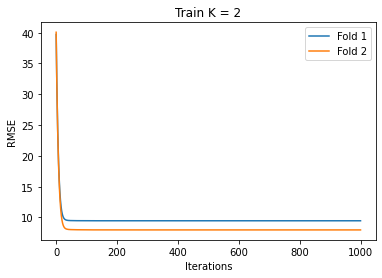

In [14]:
plot_RMSEs(all_trainRMSEs, "Train K = 2", "Iterations", "RMSE")

<module 'matplotlib.pyplot' from 'C:\\Users\\ASUS\\AppData\\Local\\Packages\\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\\LocalCache\\local-packages\\Python39\\site-packages\\matplotlib\\pyplot.py'>

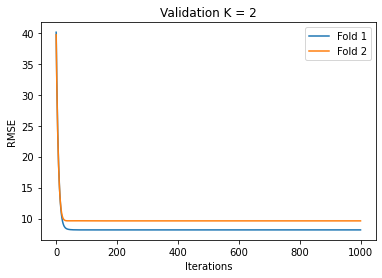

In [15]:
plot_RMSEs(all_valRMSEs, "Validation K = 2", "Iterations", "RMSE")

K = 3

In [16]:
for learning_rate in learning_rates:
    valRMSEs = []
    valMSEs = []
    trainRMSEs = []
    trainMSEs = []
    print(f'Learning Rate: {learning_rate}')
    for fold in three_folds:
        X_train, y_train, X_test, y_test = fold

        standard_scaler = StandardScaler()
        X_train = standard_scaler.fit_transform(X_train)
        X_test = standard_scaler.transform(X_test) 

        X_train = add_ones(X_train)
        X_test = add_ones(X_test)

        LR = LinearRegression(learning_rate=learning_rate, epochs=1000, early_stopping=True)
        LR.fit(X_train, y_train)
        params = LR.get_params()

        rmse_val, mse_val = evaluate_model(X_test, y_test, params)

        valRMSEs.append(rmse_val)
        valMSEs.append(mse_val)

        rmse_train, mse_train = evaluate_model(X_train, y_train, params)
        trainMSEs.append(mse_train)
        trainRMSEs.append(rmse_train)
        print(f"Validation RMSE: {rmse_val}, Validation MSE: {mse_val}")
        # print(f"Training RMSE: {rmse_train}, Training MSE: {mse_train}")
    print(f"For Validation - Average RMSE: {np.mean(valRMSEs)}, RMSE Variance: {np.var(valRMSEs)}")
    # print(f"For Validation - Average MSE: {np.mean(mse_val)}, MSE Variance: {np.var(mse_val)}")
    print(f"For Training - Average RMSE: {np.mean(trainRMSEs)}, RMSE Variance: {np.var(trainRMSEs)}")
    # print(f"For Training - Average MSE: {np.mean(mse_train)}, MSE Variance: {np.var(mse_train)}")
    print()

Learning Rate: 0.0001
Validation RMSE: 36.73947356534616, Validation MSE: 1349.7889178587693
Validation RMSE: 36.01914827001337, Validation MSE: 1297.379042097207
Validation RMSE: 35.2821101665008, Validation MSE: 1244.8272978010991
For Validation - Average RMSE: 36.01357733395344, RMSE Variance: 0.35400019704664154
For Training - Average RMSE: 36.00837256368507, RMSE Variance: 0.07546264074810426

Learning Rate: 0.001
Validation RMSE: 16.860427062435036, Validation MSE: 284.27400072769177
Validation RMSE: 17.319894362286966, Validation MSE: 299.9787407207798
Validation RMSE: 15.41354709832028, Validation MSE: 237.57743415213753
For Validation - Average RMSE: 16.53128950768076, RMSE Variance: 0.6598590801136908
For Training - Average RMSE: 16.494837105934213, RMSE Variance: 0.04413064494311388

Learning Rate: 0.01
Validation RMSE: 8.242068626301526, Validation MSE: 67.93169524066393
Validation RMSE: 10.204615502512498, Validation MSE: 104.13417755411841
Validation RMSE: 8.1617055235760

## As we can see a LR of 0.1 performs the best so we'll plot that and have a look

In [17]:
all_trainRMSEs = []
all_valRMSEs = []
RMSEs = []
MSEs = []
for fold in three_folds:
    X_train, y_train, X_test, y_test = fold
    standard_scaler = StandardScaler()
    X_train = standard_scaler.fit_transform(X_train)
    X_test = standard_scaler.transform(X_test) 
    X_train = add_ones(X_train)
    X_test = add_ones(X_test)
    LR = LinearRegression(learning_rate=0.1, epochs=1000, early_stopping=True)
    LR.fit(X_train, y_train, X_test, y_test)
    params = LR.get_params()
    all_trainRMSEs.append(LR.get_trainRMSEs())
    all_valRMSEs.append(LR.get_valRMSEs())
print()

<module 'matplotlib.pyplot' from 'C:\\Users\\ASUS\\AppData\\Local\\Packages\\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\\LocalCache\\local-packages\\Python39\\site-packages\\matplotlib\\pyplot.py'>

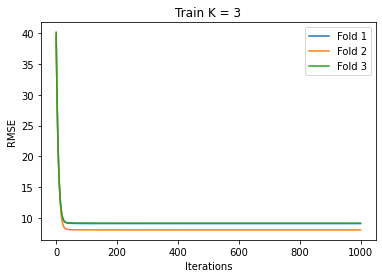

In [18]:
plot_RMSEs(all_trainRMSEs, "Train K = 3", "Iterations", "RMSE")

<module 'matplotlib.pyplot' from 'C:\\Users\\ASUS\\AppData\\Local\\Packages\\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\\LocalCache\\local-packages\\Python39\\site-packages\\matplotlib\\pyplot.py'>

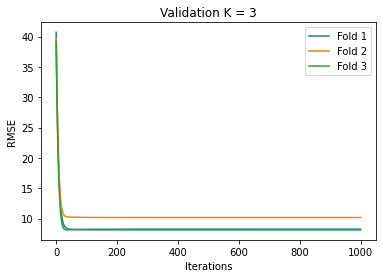

In [19]:
plot_RMSEs(all_valRMSEs, "Validation K = 3", "Iterations", "RMSE")

K = 4

In [20]:
for learning_rate in learning_rates:
    valRMSEs = []
    valMSEs = []
    trainRMSEs = []
    trainMSEs = []
    print(f'Learning Rate: {learning_rate}')
    for fold in four_folds:
        X_train, y_train, X_test, y_test = fold

        standard_scaler = StandardScaler()
        X_train = standard_scaler.fit_transform(X_train)
        X_test = standard_scaler.transform(X_test) 

        X_train = add_ones(X_train)
        X_test = add_ones(X_test)

        LR = LinearRegression(learning_rate=learning_rate, epochs=1000, early_stopping=True)
        LR.fit(X_train, y_train)
        params = LR.get_params()

        rmse_val, mse_val = evaluate_model(X_test, y_test, params)

        valRMSEs.append(rmse_val)
        valMSEs.append(mse_val)

        rmse_train, mse_train = evaluate_model(X_train, y_train, params)
        trainMSEs.append(mse_train)
        trainRMSEs.append(rmse_train)
        print(f"Validation RMSE: {rmse_val}, Validation MSE: {mse_val}")
        # print(f"Training RMSE: {rmse_train}, Training MSE: {mse_train}")
    print(f"For Validation - Average RMSE: {np.mean(valRMSEs)}, RMSE Variance: {np.var(valRMSEs)}")
    # print(f"For Validation - Average MSE: {np.mean(mse_val)}, MSE Variance: {np.var(mse_val)}")
    print(f"For Training - Average RMSE: {np.mean(trainRMSEs)}, RMSE Variance: {np.var(trainRMSEs)}")
    # print(f"For Training - Average MSE: {np.mean(mse_train)}, MSE Variance: {np.var(mse_train)}")
    print()

Learning Rate: 0.0001
Validation RMSE: 36.247718644869835, Validation MSE: 1313.8971069576442
Validation RMSE: 36.09479003905462, Validation MSE: 1302.8338679634367
Validation RMSE: 36.129290180599426, Validation MSE: 1305.3256089539582
Validation RMSE: 35.57462579986026, Validation MSE: 1265.554000800083
For Validation - Average RMSE: 36.01160616609603, RMSE Variance: 0.06686750677457182
For Training - Average RMSE: 36.00972583774011, RMSE Variance: 0.0033083854204209273

Learning Rate: 0.001
Validation RMSE: 16.288022785777667, Validation MSE: 265.2996862700125
Validation RMSE: 16.66312980076215, Validation MSE: 277.65989475704765
Validation RMSE: 17.331599052044304, Validation MSE: 300.38432570082296
Validation RMSE: 15.840916748486539, Validation MSE: 250.93464343248132
For Validation - Average RMSE: 16.530917096767666, RMSE Variance: 0.2984174798856341
For Training - Average RMSE: 16.496843437592865, RMSE Variance: 0.043591155809291134

Learning Rate: 0.01
Validation RMSE: 7.00814

## As we can see a LR of 0.01 performs the best so we'll plot that and have a look

In [21]:
all_trainRMSEs = []
all_valRMSEs = []
RMSEs = []
MSEs = []
for fold in four_folds:
    X_train, y_train, X_test, y_test = fold
    standard_scaler = StandardScaler()
    X_train = standard_scaler.fit_transform(X_train)
    X_test = standard_scaler.transform(X_test) 
    X_train = add_ones(X_train)
    X_test = add_ones(X_test)
    LR = LinearRegression(learning_rate=0.01, epochs=1000, early_stopping=True)
    LR.fit(X_train, y_train, X_test, y_test)
    params = LR.get_params()
    all_trainRMSEs.append(LR.get_trainRMSEs())
    all_valRMSEs.append(LR.get_valRMSEs())
print()

<module 'matplotlib.pyplot' from 'C:\\Users\\ASUS\\AppData\\Local\\Packages\\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\\LocalCache\\local-packages\\Python39\\site-packages\\matplotlib\\pyplot.py'>

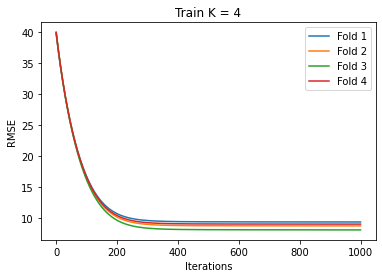

In [22]:
plot_RMSEs(all_trainRMSEs, "Train K = 4", "Iterations", "RMSE")

<module 'matplotlib.pyplot' from 'C:\\Users\\ASUS\\AppData\\Local\\Packages\\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\\LocalCache\\local-packages\\Python39\\site-packages\\matplotlib\\pyplot.py'>

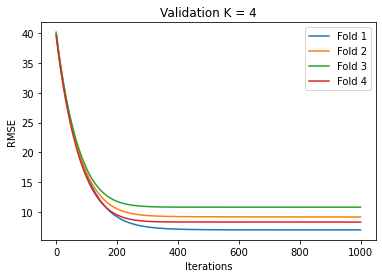

In [23]:
plot_RMSEs(all_valRMSEs, "Validation K = 4", "Iterations", "RMSE")

K = 5

In [24]:
for learning_rate in learning_rates:
    valRMSEs = []
    valMSEs = []
    trainRMSEs = []
    trainMSEs = []
    print(f'Learning Rate: {learning_rate}')
    for fold in five_folds:
        X_train, y_train, X_test, y_test = fold

        standard_scaler = StandardScaler()
        X_train = standard_scaler.fit_transform(X_train)
        X_test = standard_scaler.transform(X_test) 

        X_train = add_ones(X_train)
        X_test = add_ones(X_test)

        LR = LinearRegression(learning_rate=learning_rate, epochs=1000, early_stopping=True)
        LR.fit(X_train, y_train)
        params = LR.get_params()

        rmse_val, mse_val = evaluate_model(X_test, y_test, params)

        valRMSEs.append(rmse_val)
        valMSEs.append(mse_val)

        rmse_train, mse_train = evaluate_model(X_train, y_train, params)
        trainMSEs.append(mse_train)
        trainRMSEs.append(rmse_train)
        print(f"Validation RMSE: {rmse_val}, Validation MSE: {mse_val}")
        # print(f"Training RMSE: {rmse_train}, Training MSE: {mse_train}")
    print(f"For Validation - Average RMSE: {np.mean(valRMSEs)}, RMSE Variance: {np.var(valRMSEs)}")
    # print(f"For Validation - Average MSE: {np.mean(mse_val)}, MSE Variance: {np.var(mse_val)}")
    print(f"For Training - Average RMSE: {np.mean(trainRMSEs)}, RMSE Variance: {np.var(trainRMSEs)}")
    # print(f"For Training - Average MSE: {np.mean(mse_train)}, MSE Variance: {np.var(mse_train)}")
    print()

Learning Rate: 0.0001
Validation RMSE: 36.002555641050144, Validation MSE: 1296.1840126869115
Validation RMSE: 37.18158163913651, Validation MSE: 1382.4700131877732
Validation RMSE: 35.32325273552617, Validation MSE: 1247.7321838178568
Validation RMSE: 36.32494644686623, Validation MSE: 1319.5017343676993
Validation RMSE: 35.23164782644089, Validation MSE: 1241.2690085663571
For Validation - Average RMSE: 36.01279685780399, RMSE Variance: 0.5098530038628459
For Training - Average RMSE: 36.01050563258034, RMSE Variance: 0.033575947123506984

Learning Rate: 0.001
Validation RMSE: 15.950620949442124, Validation MSE: 254.42230867278198
Validation RMSE: 17.688283351885264, Validation MSE: 312.8753679365814
Validation RMSE: 15.439037097855426, Validation MSE: 238.36386650895608
Validation RMSE: 17.745379984223877, Validation MSE: 314.89851078449345
Validation RMSE: 15.659314606027692, Validation MSE: 245.2141339305522
For Validation - Average RMSE: 16.496527197886877, RMSE Variance: 1.019427

## As we can see a LR of 0.1 performs the best so we'll plot that and have a look

In [25]:
all_trainRMSEs = []
all_valRMSEs = []
RMSEs = []
MSEs = []
for fold in five_folds:
    X_train, y_train, X_test, y_test = fold
    standard_scaler = StandardScaler()
    X_train = standard_scaler.fit_transform(X_train)
    X_test = standard_scaler.transform(X_test) 
    X_train = add_ones(X_train)
    X_test = add_ones(X_test)
    LR = LinearRegression(learning_rate=0.1, epochs=1000, early_stopping=True)
    LR.fit(X_train, y_train, X_test, y_test)
    params = LR.get_params()
    all_trainRMSEs.append(LR.get_trainRMSEs())
    all_valRMSEs.append(LR.get_valRMSEs())
print()

<module 'matplotlib.pyplot' from 'C:\\Users\\ASUS\\AppData\\Local\\Packages\\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\\LocalCache\\local-packages\\Python39\\site-packages\\matplotlib\\pyplot.py'>

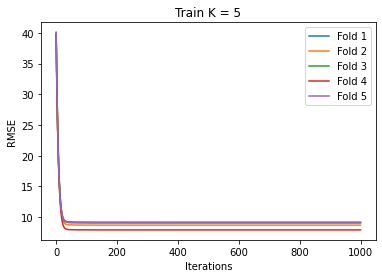

In [26]:
plot_RMSEs(all_trainRMSEs, "Train K = 5", "Iterations", "RMSE")

<module 'matplotlib.pyplot' from 'C:\\Users\\ASUS\\AppData\\Local\\Packages\\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\\LocalCache\\local-packages\\Python39\\site-packages\\matplotlib\\pyplot.py'>

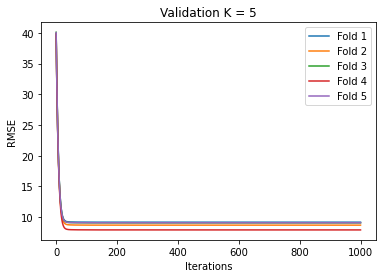

In [27]:
plot_RMSEs(all_trainRMSEs, "Validation K = 5", "Iterations", "RMSE")

K = 5 with all LRs (except 0.1 which is plotted above)

In [28]:
all_trainRMSEs = []
all_valRMSEs = []
RMSEs = []
MSEs = []
for fold in five_folds:
    X_train, y_train, X_test, y_test = fold
    standard_scaler = StandardScaler()
    X_train = standard_scaler.fit_transform(X_train)
    X_test = standard_scaler.transform(X_test) 
    X_train = add_ones(X_train)
    X_test = add_ones(X_test)
    LR = LinearRegression(learning_rate=0.0001, epochs=1000, early_stopping=True)
    LR.fit(X_train, y_train, X_test, y_test)
    params = LR.get_params()
    all_trainRMSEs.append(LR.get_trainRMSEs())
    all_valRMSEs.append(LR.get_valRMSEs())
print()

<module 'matplotlib.pyplot' from 'C:\\Users\\ASUS\\AppData\\Local\\Packages\\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\\LocalCache\\local-packages\\Python39\\site-packages\\matplotlib\\pyplot.py'>

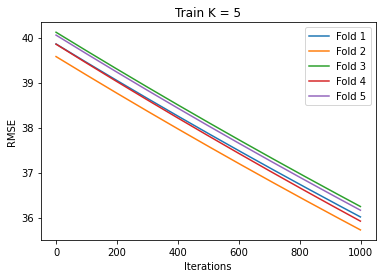

In [29]:
plot_RMSEs(all_trainRMSEs, "Train K = 5", "Iterations", "RMSE")

<module 'matplotlib.pyplot' from 'C:\\Users\\ASUS\\AppData\\Local\\Packages\\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\\LocalCache\\local-packages\\Python39\\site-packages\\matplotlib\\pyplot.py'>

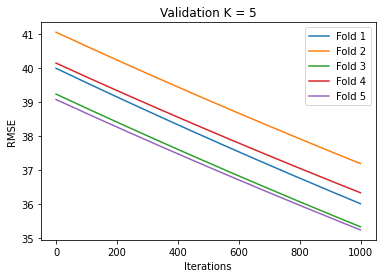

In [30]:
plot_RMSEs(all_valRMSEs, "Validation K = 5", "Iterations", "RMSE")

In [31]:
all_trainRMSEs = []
all_valRMSEs = []
RMSEs = []
MSEs = []
for fold in five_folds:
    X_train, y_train, X_test, y_test = fold
    standard_scaler = StandardScaler()
    X_train = standard_scaler.fit_transform(X_train)
    X_test = standard_scaler.transform(X_test) 
    X_train = add_ones(X_train)
    X_test = add_ones(X_test)
    LR = LinearRegression(learning_rate=0.001, epochs=1000, early_stopping=True)
    LR.fit(X_train, y_train, X_test, y_test)
    params = LR.get_params()
    all_trainRMSEs.append(LR.get_trainRMSEs())
    all_valRMSEs.append(LR.get_valRMSEs())
print()

<module 'matplotlib.pyplot' from 'C:\\Users\\ASUS\\AppData\\Local\\Packages\\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\\LocalCache\\local-packages\\Python39\\site-packages\\matplotlib\\pyplot.py'>

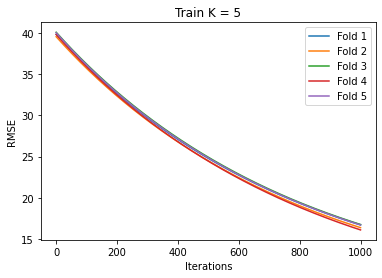

In [32]:
plot_RMSEs(all_trainRMSEs, "Train K = 5", "Iterations", "RMSE")

<module 'matplotlib.pyplot' from 'C:\\Users\\ASUS\\AppData\\Local\\Packages\\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\\LocalCache\\local-packages\\Python39\\site-packages\\matplotlib\\pyplot.py'>

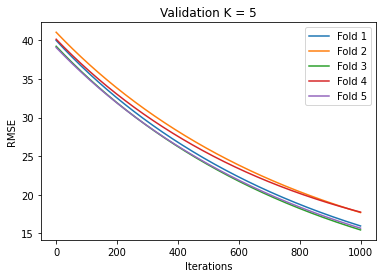

In [33]:
plot_RMSEs(all_valRMSEs, "Validation K = 5", "Iterations", "RMSE")

In [34]:
all_trainRMSEs = []
all_valRMSEs = []
RMSEs = []
MSEs = []
for fold in five_folds:
    X_train, y_train, X_test, y_test = fold
    standard_scaler = StandardScaler()
    X_train = standard_scaler.fit_transform(X_train)
    X_test = standard_scaler.transform(X_test) 
    X_train = add_ones(X_train)
    X_test = add_ones(X_test)
    LR = LinearRegression(learning_rate=0.01, epochs=1000, early_stopping=True)
    LR.fit(X_train, y_train, X_test, y_test)
    params = LR.get_params()
    all_trainRMSEs.append(LR.get_trainRMSEs())
    all_valRMSEs.append(LR.get_valRMSEs())
print()

<module 'matplotlib.pyplot' from 'C:\\Users\\ASUS\\AppData\\Local\\Packages\\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\\LocalCache\\local-packages\\Python39\\site-packages\\matplotlib\\pyplot.py'>

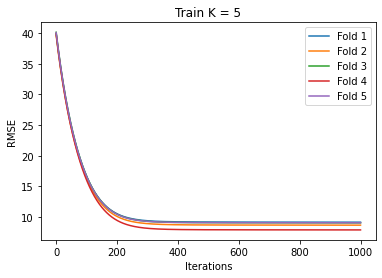

In [35]:
plot_RMSEs(all_trainRMSEs, "Train K = 5", "Iterations", "RMSE")

<module 'matplotlib.pyplot' from 'C:\\Users\\ASUS\\AppData\\Local\\Packages\\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\\LocalCache\\local-packages\\Python39\\site-packages\\matplotlib\\pyplot.py'>

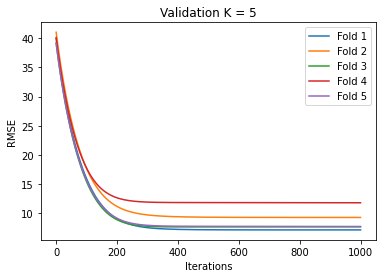

In [36]:
plot_RMSEs(all_valRMSEs, "Validation K = 5", "Iterations", "RMSE")

In [37]:
all_trainRMSEs = []
all_valRMSEs = []
RMSEs = []
MSEs = []
for fold in five_folds:
    X_train, y_train, X_test, y_test = fold
    standard_scaler = StandardScaler()
    X_train = standard_scaler.fit_transform(X_train)
    X_test = standard_scaler.transform(X_test) 
    X_train = add_ones(X_train)
    X_test = add_ones(X_test)
    LR = LinearRegression(learning_rate=1, epochs=1000, early_stopping=True)
    LR.fit(X_train, y_train, X_test, y_test)
    params = LR.get_params()
    all_trainRMSEs.append(LR.get_trainRMSEs())
    all_valRMSEs.append(LR.get_valRMSEs())
print()

<module 'matplotlib.pyplot' from 'C:\\Users\\ASUS\\AppData\\Local\\Packages\\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\\LocalCache\\local-packages\\Python39\\site-packages\\matplotlib\\pyplot.py'>

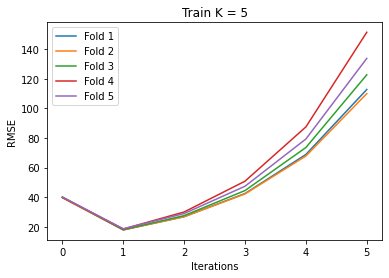

In [38]:
plot_RMSEs(all_trainRMSEs, "Train K = 5", "Iterations", "RMSE")

<module 'matplotlib.pyplot' from 'C:\\Users\\ASUS\\AppData\\Local\\Packages\\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\\LocalCache\\local-packages\\Python39\\site-packages\\matplotlib\\pyplot.py'>

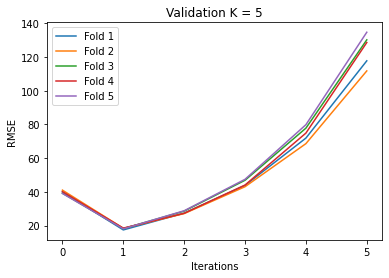

In [39]:
plot_RMSEs(all_valRMSEs, "Validation K = 5", "Iterations", "RMSE")

In [40]:
all_trainRMSEs = []
all_valRMSEs = []
RMSEs = []
MSEs = []
for fold in five_folds:
    X_train, y_train, X_test, y_test = fold
    standard_scaler = StandardScaler()
    X_train = standard_scaler.fit_transform(X_train)
    X_test = standard_scaler.transform(X_test) 
    X_train = add_ones(X_train)
    X_test = add_ones(X_test)
    LR = LinearRegression(learning_rate=10, epochs=1000, early_stopping=True)
    LR.fit(X_train, y_train, X_test, y_test)
    params = LR.get_params()
    all_trainRMSEs.append(LR.get_trainRMSEs())
    all_valRMSEs.append(LR.get_valRMSEs())
print()

<module 'matplotlib.pyplot' from 'C:\\Users\\ASUS\\AppData\\Local\\Packages\\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\\LocalCache\\local-packages\\Python39\\site-packages\\matplotlib\\pyplot.py'>

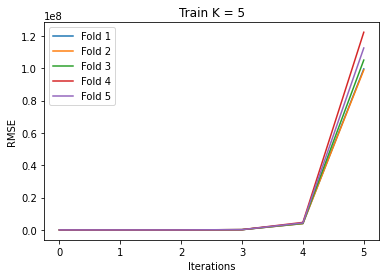

In [41]:
plot_RMSEs(all_trainRMSEs, "Train K = 5", "Iterations", "RMSE")

<module 'matplotlib.pyplot' from 'C:\\Users\\ASUS\\AppData\\Local\\Packages\\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\\LocalCache\\local-packages\\Python39\\site-packages\\matplotlib\\pyplot.py'>

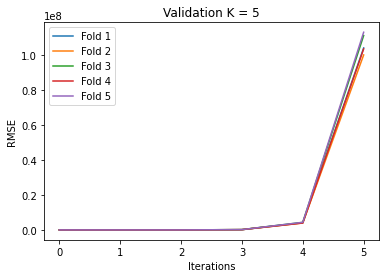

In [42]:
plot_RMSEs(all_valRMSEs, "Validation K = 5", "Iterations", "RMSE")

Train-Test RMSEs for K = 5

In [43]:
for learning_rate in learning_rates:
    val_RMSEs = []
    val_MSEs = []
    train_RMSEs = []
    train_MSEs = []
    print(f'Learning Rate: {learning_rate}')
    for fold in five_folds:
        X_train, y_train, X_test, y_test = fold

        standard_scaler = StandardScaler()
        X_train = standard_scaler.fit_transform(X_train)
        X_test = standard_scaler.transform(X_test) 

        X_train = add_ones(X_train)
        X_test = add_ones(X_test)

        LR = LinearRegression(learning_rate=learning_rate, epochs=1000, early_stopping=True)
        LR.fit(X_train, y_train)
        params = LR.get_params()

        val_RMSE, val_MSE = evaluate_model(X_test, y_test, params)

        val_RMSEs.append(val_RMSE)
        val_MSEs.append(val_MSE)

        train_RMSE, train_MSE = evaluate_model(X_train, y_train, params)

        train_RMSEs.append(train_RMSE)
        train_MSEs.append(train_MSE)

        # print('RMSE: {}, MSE: {}'.format(rmse, mse))
    print(f"Average Val RMSE: {np.mean(val_RMSEs)}, RMSE Variance: {np.var(val_RMSEs)}")
    print(f"Average Train RMSE: {np.mean(train_RMSEs)}, RMSE Variance: {np.var(train_RMSEs)}")
    print()

Learning Rate: 0.0001
Average Val RMSE: 36.01279685780399, RMSE Variance: 0.5098530038628459
Average Train RMSE: 36.01050563258034, RMSE Variance: 0.033575947123506984

Learning Rate: 0.001
Average Val RMSE: 16.496527197886877, RMSE Variance: 1.0194279760515688
Average Train RMSE: 16.502311660962423, RMSE Variance: 0.06453214850134735

Learning Rate: 0.01
Average Val RMSE: 8.705403450836773, RMSE Variance: 2.8712651197947343
Average Train RMSE: 8.785781139555151, RMSE Variance: 0.21633424581739652

Learning Rate: 0.1
Average Val RMSE: 8.703710716525489, RMSE Variance: 2.823659336631281
Average Train RMSE: 8.778941029351845, RMSE Variance: 0.21652764713063033

Learning Rate: 1
Average Val RMSE: 124.57747458646664, RMSE Variance: 72.19475033551696
Average Train RMSE: 126.2045120198442, RMSE Variance: 230.68650614413235

Learning Rate: 10
Average Val RMSE: 106486004.68005028, RMSE Variance: 24241647377181.82
Average Train RMSE: 107607305.64109787, RMSE Variance: 77049656122183.4



# Regularization

In [44]:
reg_lambdas = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100]

## Ridge

In [45]:
for reg_lambda in reg_lambdas:
    valRMSEs = []
    valMSEs = []
    trainRMSEs = []
    trainMSEs = []
    print(f'Regularization Parameter: {reg_lambda}')
    for fold in five_folds:
        X_train, y_train, X_test, y_test = fold

        standard_scaler = StandardScaler()
        X_train = standard_scaler.fit_transform(X_train)
        X_test = standard_scaler.transform(X_test) 

        X_train = add_ones(X_train)
        X_test = add_ones(X_test)

        LR = LinearRegression(learning_rate=0.1, epochs=1000, early_stopping=True, regularization='Ridge', reg_lambda=reg_lambda)
        LR.fit(X_train, y_train)
        params = LR.get_params()

        rmse_val, mse_val = evaluate_model(X_test, y_test, params)

        valRMSEs.append(rmse_val)
        valMSEs.append(mse_val)

        rmse_train, mse_train = evaluate_model(X_train, y_train, params)
        trainMSEs.append(mse_train)
        trainRMSEs.append(rmse_train)
        # print(f"Validation RMSE: {rmse_val}, Validation MSE: {mse_val}")
        # print(f"Training RMSE: {rmse_train}, Training MSE: {mse_train}")
    print(f"For Validation - Average RMSE: {np.mean(valRMSEs)}, RMSE Variance: {np.var(valRMSEs)}")
    # print(f"For Validation - Average MSE: {np.mean(mse_val)}, MSE Variance: {np.var(mse_val)}")
    print(f"For Training - Average RMSE: {np.mean(trainRMSEs)}, RMSE Variance: {np.var(trainRMSEs)}")
    # print(f"For Training - Average MSE: {np.mean(mse_train)}, MSE Variance: {np.var(mse_train)}")
    print()

Regularization Parameter: 1e-05
For Validation - Average RMSE: 8.70370886792957, RMSE Variance: 2.8236234615944715
For Training - Average RMSE: 8.778941064870889, RMSE Variance: 0.21652764538583974

Regularization Parameter: 0.0001
For Validation - Average RMSE: 8.703695553671981, RMSE Variance: 2.823299404492735
For Training - Average RMSE: 8.778944578429293, RMSE Variance: 0.21652747314345916

Regularization Parameter: 0.001
For Validation - Average RMSE: 8.703889672477846, RMSE Variance: 2.81994233619207
For Training - Average RMSE: 8.779294290608846, RMSE Variance: 0.21651031524722947

Regularization Parameter: 0.01
For Validation - Average RMSE: 8.736885225993767, RMSE Variance: 2.7752938787261368
For Training - Average RMSE: 8.812680651250712, RMSE Variance: 0.21486662361581602

Regularization Parameter: 0.1
For Validation - Average RMSE: 10.859364207752135, RMSE Variance: 1.9071935836059317
For Training - Average RMSE: 10.897660996629977, RMSE Variance: 0.1392299859524072

Regul

In [46]:
all_trainRMSEs = []
all_valRMSEs = []
RMSEs = []
MSEs = []
for fold in five_folds:
    X_train, y_train, X_test, y_test = fold
    standard_scaler = StandardScaler()
    X_train = standard_scaler.fit_transform(X_train)
    X_test = standard_scaler.transform(X_test) 
    X_train = add_ones(X_train)
    X_test = add_ones(X_test)
    LR = LinearRegression(learning_rate=0.1, epochs=1000, early_stopping=True, regularization='Ridge', reg_lambda=1e-5)
    LR.fit(X_train, y_train, X_test, y_test)
    params = LR.get_params()
    all_trainRMSEs.append(LR.get_trainRMSEs())
    all_valRMSEs.append(LR.get_valRMSEs())
print()

<module 'matplotlib.pyplot' from 'C:\\Users\\ASUS\\AppData\\Local\\Packages\\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\\LocalCache\\local-packages\\Python39\\site-packages\\matplotlib\\pyplot.py'>

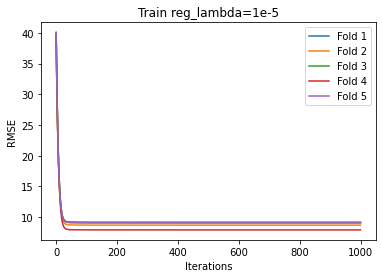

In [47]:
plot_RMSEs(all_trainRMSEs, "Train reg_lambda=1e-5", "Iterations", "RMSE")

<module 'matplotlib.pyplot' from 'C:\\Users\\ASUS\\AppData\\Local\\Packages\\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\\LocalCache\\local-packages\\Python39\\site-packages\\matplotlib\\pyplot.py'>

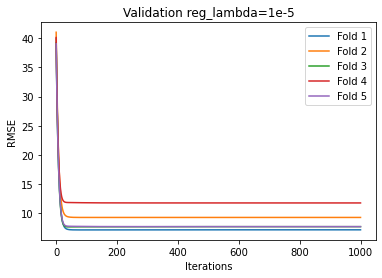

In [48]:
plot_RMSEs(all_valRMSEs, "Validation reg_lambda=1e-5", "Iterations", "RMSE")

In [49]:
all_trainRMSEs = []
all_valRMSEs = []
RMSEs = []
MSEs = []
for fold in five_folds:
    X_train, y_train, X_test, y_test = fold
    standard_scaler = StandardScaler()
    X_train = standard_scaler.fit_transform(X_train)
    X_test = standard_scaler.transform(X_test) 
    X_train = add_ones(X_train)
    X_test = add_ones(X_test)
    LR = LinearRegression(learning_rate=0.1, epochs=1000, early_stopping=True, regularization='Ridge', reg_lambda=1e-4)
    LR.fit(X_train, y_train, X_test, y_test)
    params = LR.get_params()
    all_trainRMSEs.append(LR.get_trainRMSEs())
    all_valRMSEs.append(LR.get_valRMSEs())
print()

<module 'matplotlib.pyplot' from 'C:\\Users\\ASUS\\AppData\\Local\\Packages\\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\\LocalCache\\local-packages\\Python39\\site-packages\\matplotlib\\pyplot.py'>

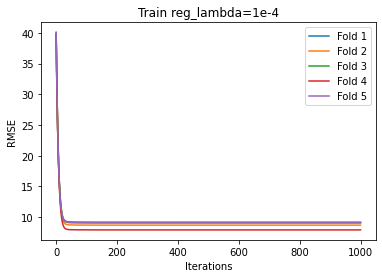

In [50]:
plot_RMSEs(all_trainRMSEs, "Train reg_lambda=1e-4", "Iterations", "RMSE")

<module 'matplotlib.pyplot' from 'C:\\Users\\ASUS\\AppData\\Local\\Packages\\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\\LocalCache\\local-packages\\Python39\\site-packages\\matplotlib\\pyplot.py'>

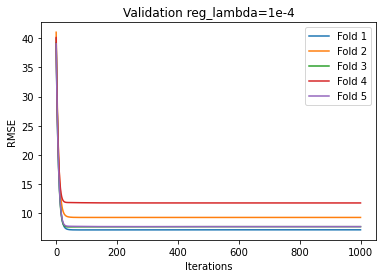

In [51]:
plot_RMSEs(all_valRMSEs, "Validation reg_lambda=1e-4", "Iterations", "RMSE")

In [52]:
all_trainRMSEs = []
all_valRMSEs = []
RMSEs = []
MSEs = []
for fold in five_folds:
    X_train, y_train, X_test, y_test = fold
    standard_scaler = StandardScaler()
    X_train = standard_scaler.fit_transform(X_train)
    X_test = standard_scaler.transform(X_test) 
    X_train = add_ones(X_train)
    X_test = add_ones(X_test)
    LR = LinearRegression(learning_rate=0.1, epochs=1000, early_stopping=True, regularization='Ridge', reg_lambda=1e-3)
    LR.fit(X_train, y_train, X_test, y_test)
    params = LR.get_params()
    all_trainRMSEs.append(LR.get_trainRMSEs())
    all_valRMSEs.append(LR.get_valRMSEs())
print()

<module 'matplotlib.pyplot' from 'C:\\Users\\ASUS\\AppData\\Local\\Packages\\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\\LocalCache\\local-packages\\Python39\\site-packages\\matplotlib\\pyplot.py'>

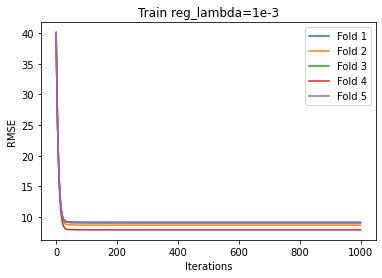

In [53]:
plot_RMSEs(all_trainRMSEs, "Train reg_lambda=1e-3", "Iterations", "RMSE")

<module 'matplotlib.pyplot' from 'C:\\Users\\ASUS\\AppData\\Local\\Packages\\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\\LocalCache\\local-packages\\Python39\\site-packages\\matplotlib\\pyplot.py'>

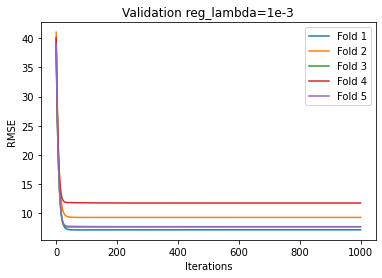

In [54]:
plot_RMSEs(all_valRMSEs, "Validation reg_lambda=1e-3", "Iterations", "RMSE")

In [55]:
all_trainRMSEs = []
all_valRMSEs = []
RMSEs = []
MSEs = []
for fold in five_folds:
    X_train, y_train, X_test, y_test = fold
    standard_scaler = StandardScaler()
    X_train = standard_scaler.fit_transform(X_train)
    X_test = standard_scaler.transform(X_test) 
    X_train = add_ones(X_train)
    X_test = add_ones(X_test)
    LR = LinearRegression(learning_rate=0.1, epochs=1000, early_stopping=True, regularization='Ridge', reg_lambda=1e-2)
    LR.fit(X_train, y_train, X_test, y_test)
    params = LR.get_params()
    all_trainRMSEs.append(LR.get_trainRMSEs())
    all_valRMSEs.append(LR.get_valRMSEs())
print()

<module 'matplotlib.pyplot' from 'C:\\Users\\ASUS\\AppData\\Local\\Packages\\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\\LocalCache\\local-packages\\Python39\\site-packages\\matplotlib\\pyplot.py'>

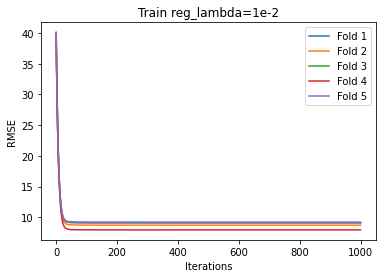

In [56]:
plot_RMSEs(all_trainRMSEs, "Train reg_lambda=1e-2", "Iterations", "RMSE")

<module 'matplotlib.pyplot' from 'C:\\Users\\ASUS\\AppData\\Local\\Packages\\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\\LocalCache\\local-packages\\Python39\\site-packages\\matplotlib\\pyplot.py'>

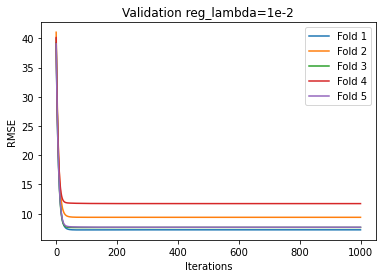

In [57]:
plot_RMSEs(all_valRMSEs, "Validation reg_lambda=1e-2", "Iterations", "RMSE")

In [58]:
all_trainRMSEs = []
all_valRMSEs = []
RMSEs = []
MSEs = []
for fold in five_folds:
    X_train, y_train, X_test, y_test = fold
    standard_scaler = StandardScaler()
    X_train = standard_scaler.fit_transform(X_train)
    X_test = standard_scaler.transform(X_test) 
    X_train = add_ones(X_train)
    X_test = add_ones(X_test)
    LR = LinearRegression(learning_rate=0.1, epochs=1000, early_stopping=True, regularization='Ridge', reg_lambda=1e-1)
    LR.fit(X_train, y_train, X_test, y_test)
    params = LR.get_params()
    all_trainRMSEs.append(LR.get_trainRMSEs())
    all_valRMSEs.append(LR.get_valRMSEs())
print()

<module 'matplotlib.pyplot' from 'C:\\Users\\ASUS\\AppData\\Local\\Packages\\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\\LocalCache\\local-packages\\Python39\\site-packages\\matplotlib\\pyplot.py'>

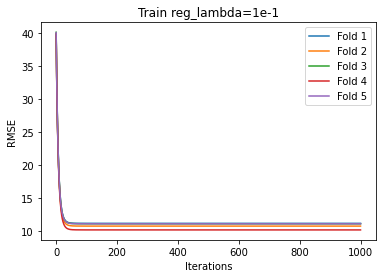

In [59]:
plot_RMSEs(all_trainRMSEs, "Train reg_lambda=1e-1", "Iterations", "RMSE")

<module 'matplotlib.pyplot' from 'C:\\Users\\ASUS\\AppData\\Local\\Packages\\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\\LocalCache\\local-packages\\Python39\\site-packages\\matplotlib\\pyplot.py'>

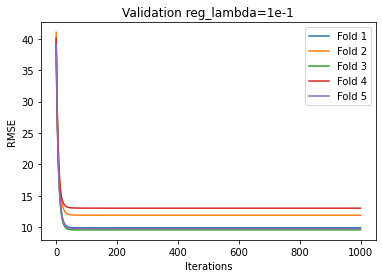

In [60]:
plot_RMSEs(all_valRMSEs, "Validation reg_lambda=1e-1", "Iterations", "RMSE")

In [61]:
all_trainRMSEs = []
all_valRMSEs = []
RMSEs = []
MSEs = []
for fold in five_folds:
    X_train, y_train, X_test, y_test = fold
    standard_scaler = StandardScaler()
    X_train = standard_scaler.fit_transform(X_train)
    X_test = standard_scaler.transform(X_test) 
    X_train = add_ones(X_train)
    X_test = add_ones(X_test)
    LR = LinearRegression(learning_rate=0.1, epochs=1000, early_stopping=True, regularization='Ridge', reg_lambda=1)
    LR.fit(X_train, y_train, X_test, y_test)
    params = LR.get_params()
    all_trainRMSEs.append(LR.get_trainRMSEs())
    all_valRMSEs.append(LR.get_valRMSEs())
print()

<module 'matplotlib.pyplot' from 'C:\\Users\\ASUS\\AppData\\Local\\Packages\\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\\LocalCache\\local-packages\\Python39\\site-packages\\matplotlib\\pyplot.py'>

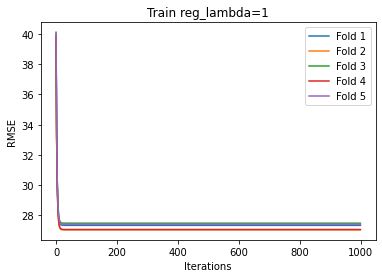

In [62]:
plot_RMSEs(all_trainRMSEs, "Train reg_lambda=1", "Iterations", "RMSE")

<module 'matplotlib.pyplot' from 'C:\\Users\\ASUS\\AppData\\Local\\Packages\\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\\LocalCache\\local-packages\\Python39\\site-packages\\matplotlib\\pyplot.py'>

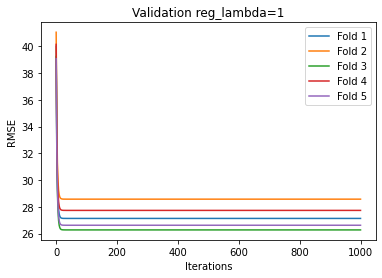

In [63]:
plot_RMSEs(all_valRMSEs, "Validation reg_lambda=1", "Iterations", "RMSE")

In [64]:
all_trainRMSEs = []
all_valRMSEs = []
RMSEs = []
MSEs = []
for fold in five_folds:
    X_train, y_train, X_test, y_test = fold
    standard_scaler = StandardScaler()
    X_train = standard_scaler.fit_transform(X_train)
    X_test = standard_scaler.transform(X_test) 
    X_train = add_ones(X_train)
    X_test = add_ones(X_test)
    LR = LinearRegression(learning_rate=0.1, epochs=1000, early_stopping=True, regularization='Ridge', reg_lambda=10)
    LR.fit(X_train, y_train, X_test, y_test)
    params = LR.get_params()
    all_trainRMSEs.append(LR.get_trainRMSEs())
    all_valRMSEs.append(LR.get_valRMSEs())
print()

<module 'matplotlib.pyplot' from 'C:\\Users\\ASUS\\AppData\\Local\\Packages\\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\\LocalCache\\local-packages\\Python39\\site-packages\\matplotlib\\pyplot.py'>

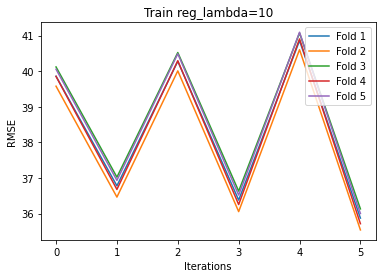

In [65]:
plot_RMSEs(all_trainRMSEs, "Train reg_lambda=10", "Iterations", "RMSE")

<module 'matplotlib.pyplot' from 'C:\\Users\\ASUS\\AppData\\Local\\Packages\\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\\LocalCache\\local-packages\\Python39\\site-packages\\matplotlib\\pyplot.py'>

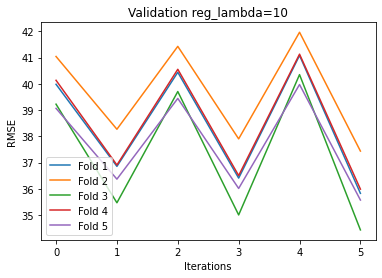

In [66]:
plot_RMSEs(all_valRMSEs, "Validation reg_lambda=10", "Iterations", "RMSE")

In [67]:
all_trainRMSEs = []
all_valRMSEs = []
RMSEs = []
MSEs = []
for fold in five_folds:
    X_train, y_train, X_test, y_test = fold
    standard_scaler = StandardScaler()
    X_train = standard_scaler.fit_transform(X_train)
    X_test = standard_scaler.transform(X_test) 
    X_train = add_ones(X_train)
    X_test = add_ones(X_test)
    LR = LinearRegression(learning_rate=0.1, epochs=1000, early_stopping=True, regularization='Ridge', reg_lambda=100)
    LR.fit(X_train, y_train, X_test, y_test)
    params = LR.get_params()
    all_trainRMSEs.append(LR.get_trainRMSEs())
    all_valRMSEs.append(LR.get_valRMSEs())
print()

<module 'matplotlib.pyplot' from 'C:\\Users\\ASUS\\AppData\\Local\\Packages\\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\\LocalCache\\local-packages\\Python39\\site-packages\\matplotlib\\pyplot.py'>

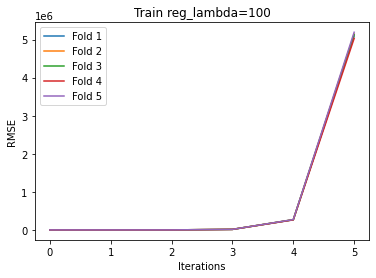

In [68]:
plot_RMSEs(all_trainRMSEs, "Train reg_lambda=100", "Iterations", "RMSE")

<module 'matplotlib.pyplot' from 'C:\\Users\\ASUS\\AppData\\Local\\Packages\\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\\LocalCache\\local-packages\\Python39\\site-packages\\matplotlib\\pyplot.py'>

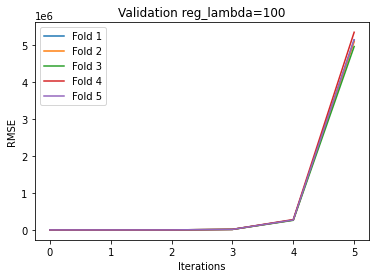

In [69]:
plot_RMSEs(all_valRMSEs, "Validation reg_lambda=100", "Iterations", "RMSE")

## Lasso

In [70]:
for reg_lambda in reg_lambdas:
    valRMSEs = []
    valMSEs = []
    trainRMSEs = []
    trainMSEs = []
    print(f'Regularization Parameter: {reg_lambda}')
    for fold in five_folds:
        X_train, y_train, X_test, y_test = fold

        standard_scaler = StandardScaler()
        X_train = standard_scaler.fit_transform(X_train)
        X_test = standard_scaler.transform(X_test) 

        X_train = add_ones(X_train)
        X_test = add_ones(X_test)

        LR = LinearRegression(learning_rate=0.1, epochs=1000, early_stopping=True, regularization='Lasso', reg_lambda=reg_lambda)
        LR.fit(X_train, y_train)
        params = LR.get_params()

        rmse_val, mse_val = evaluate_model(X_test, y_test, params)

        valRMSEs.append(rmse_val)
        valMSEs.append(mse_val)

        rmse_train, mse_train = evaluate_model(X_train, y_train, params)
        trainMSEs.append(mse_train)
        trainRMSEs.append(rmse_train)
        # print(f"Validation RMSE: {rmse_val}, Validation MSE: {mse_val}")
        # print(f"Training RMSE: {rmse_train}, Training MSE: {mse_train}")
    print(f"For Validation - Average RMSE: {np.mean(valRMSEs)}, RMSE Variance: {np.var(valRMSEs)}")
    # print(f"For Validation - Average MSE: {np.mean(mse_val)}, MSE Variance: {np.var(mse_val)}")
    print(f"For Training - Average RMSE: {np.mean(trainRMSEs)}, RMSE Variance: {np.var(trainRMSEs)}")
    # print(f"For Training - Average MSE: {np.mean(mse_train)}, MSE Variance: {np.var(mse_train)}")
    print()

Regularization Parameter: 1e-05
For Validation - Average RMSE: 8.703709672191906, RMSE Variance: 2.823658648322029
For Training - Average RMSE: 8.778941029421645, RMSE Variance: 0.21652764714807127

Regularization Parameter: 0.0001
For Validation - Average RMSE: 8.703700280194044, RMSE Variance: 2.8236524441959454
For Training - Average RMSE: 8.778941036234235, RMSE Variance: 0.2165276488039587

Regularization Parameter: 0.001
For Validation - Average RMSE: 8.7036070536675, RMSE Variance: 2.8235894778201622
For Training - Average RMSE: 8.77894171661394, RMSE Variance: 0.21652781375555175

Regularization Parameter: 0.01
For Validation - Average RMSE: 8.702744151366518, RMSE Variance: 2.822867132079941
For Training - Average RMSE: 8.77900974551358, RMSE Variance: 0.21654430284622145

Regularization Parameter: 0.1
For Validation - Average RMSE: 8.701422313685669, RMSE Variance: 2.8049388848522137
For Training - Average RMSE: 8.783382032860445, RMSE Variance: 0.21721293490135185

Regulariz

In [71]:
all_trainRMSEs = []
all_valRMSEs = []
RMSEs = []
MSEs = []
for fold in five_folds:
    X_train, y_train, X_test, y_test = fold
    standard_scaler = StandardScaler()
    X_train = standard_scaler.fit_transform(X_train)
    X_test = standard_scaler.transform(X_test) 
    X_train = add_ones(X_train)
    X_test = add_ones(X_test)
    LR = LinearRegression(learning_rate=0.1, epochs=1000, early_stopping=True, regularization='Lasso', reg_lambda=1e-5)
    LR.fit(X_train, y_train, X_test, y_test)
    params = LR.get_params()
    all_trainRMSEs.append(LR.get_trainRMSEs())
    all_valRMSEs.append(LR.get_valRMSEs())
print()

<module 'matplotlib.pyplot' from 'C:\\Users\\ASUS\\AppData\\Local\\Packages\\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\\LocalCache\\local-packages\\Python39\\site-packages\\matplotlib\\pyplot.py'>

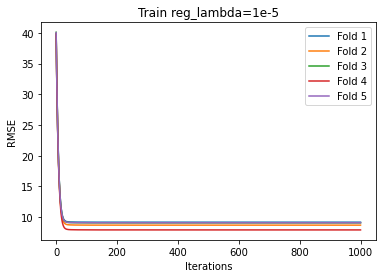

In [72]:
plot_RMSEs(all_trainRMSEs, "Train reg_lambda=1e-5", "Iterations", "RMSE")

<module 'matplotlib.pyplot' from 'C:\\Users\\ASUS\\AppData\\Local\\Packages\\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\\LocalCache\\local-packages\\Python39\\site-packages\\matplotlib\\pyplot.py'>

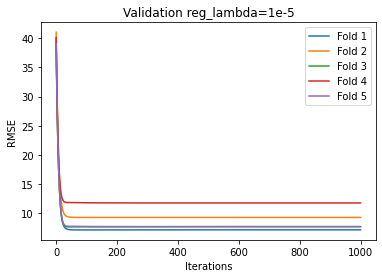

In [73]:
plot_RMSEs(all_valRMSEs, "Validation reg_lambda=1e-5", "Iterations", "RMSE")

In [74]:
all_trainRMSEs = []
all_valRMSEs = []
RMSEs = []
MSEs = []
for fold in five_folds:
    X_train, y_train, X_test, y_test = fold
    standard_scaler = StandardScaler()
    X_train = standard_scaler.fit_transform(X_train)
    X_test = standard_scaler.transform(X_test) 
    X_train = add_ones(X_train)
    X_test = add_ones(X_test)
    LR = LinearRegression(learning_rate=0.1, epochs=1000, early_stopping=True, regularization='Lasso', reg_lambda=1e-4)
    LR.fit(X_train, y_train, X_test, y_test)
    params = LR.get_params()
    all_trainRMSEs.append(LR.get_trainRMSEs())
    all_valRMSEs.append(LR.get_valRMSEs())
print()

<module 'matplotlib.pyplot' from 'C:\\Users\\ASUS\\AppData\\Local\\Packages\\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\\LocalCache\\local-packages\\Python39\\site-packages\\matplotlib\\pyplot.py'>

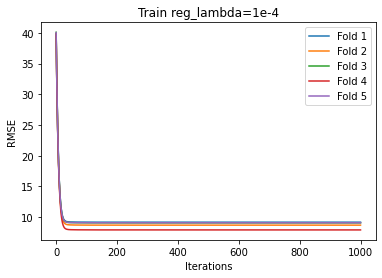

In [75]:
plot_RMSEs(all_trainRMSEs, "Train reg_lambda=1e-4", "Iterations", "RMSE")

<module 'matplotlib.pyplot' from 'C:\\Users\\ASUS\\AppData\\Local\\Packages\\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\\LocalCache\\local-packages\\Python39\\site-packages\\matplotlib\\pyplot.py'>

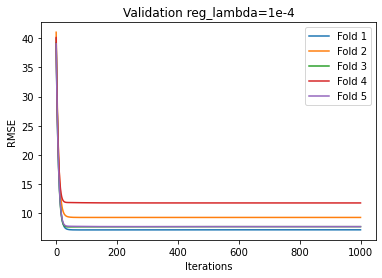

In [76]:
plot_RMSEs(all_valRMSEs, "Validation reg_lambda=1e-4", "Iterations", "RMSE")

In [77]:
all_trainRMSEs = []
all_valRMSEs = []
RMSEs = []
MSEs = []
for fold in five_folds:
    X_train, y_train, X_test, y_test = fold
    standard_scaler = StandardScaler()
    X_train = standard_scaler.fit_transform(X_train)
    X_test = standard_scaler.transform(X_test) 
    X_train = add_ones(X_train)
    X_test = add_ones(X_test)
    LR = LinearRegression(learning_rate=0.1, epochs=1000, early_stopping=True, regularization='Lasso', reg_lambda=1e-3)
    LR.fit(X_train, y_train, X_test, y_test)
    params = LR.get_params()
    all_trainRMSEs.append(LR.get_trainRMSEs())
    all_valRMSEs.append(LR.get_valRMSEs())
print()

<module 'matplotlib.pyplot' from 'C:\\Users\\ASUS\\AppData\\Local\\Packages\\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\\LocalCache\\local-packages\\Python39\\site-packages\\matplotlib\\pyplot.py'>

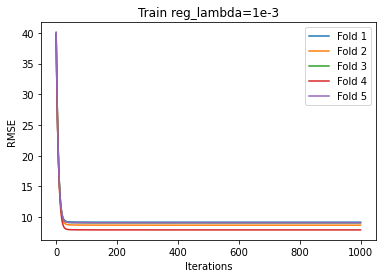

In [78]:
plot_RMSEs(all_trainRMSEs, "Train reg_lambda=1e-3", "Iterations", "RMSE")

<module 'matplotlib.pyplot' from 'C:\\Users\\ASUS\\AppData\\Local\\Packages\\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\\LocalCache\\local-packages\\Python39\\site-packages\\matplotlib\\pyplot.py'>

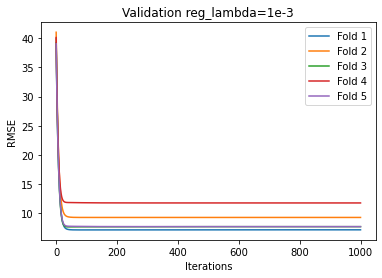

In [79]:
plot_RMSEs(all_valRMSEs, "Validation reg_lambda=1e-3", "Iterations", "RMSE")

In [80]:
all_trainRMSEs = []
all_valRMSEs = []
RMSEs = []
MSEs = []
for fold in five_folds:
    X_train, y_train, X_test, y_test = fold
    standard_scaler = StandardScaler()
    X_train = standard_scaler.fit_transform(X_train)
    X_test = standard_scaler.transform(X_test) 
    X_train = add_ones(X_train)
    X_test = add_ones(X_test)
    LR = LinearRegression(learning_rate=0.1, epochs=1000, early_stopping=True, regularization='Lasso', reg_lambda=1e-2)
    LR.fit(X_train, y_train, X_test, y_test)
    params = LR.get_params()
    all_trainRMSEs.append(LR.get_trainRMSEs())
    all_valRMSEs.append(LR.get_valRMSEs())
print()

<module 'matplotlib.pyplot' from 'C:\\Users\\ASUS\\AppData\\Local\\Packages\\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\\LocalCache\\local-packages\\Python39\\site-packages\\matplotlib\\pyplot.py'>

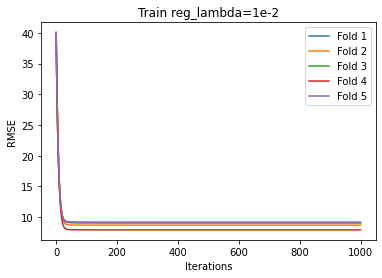

In [81]:
plot_RMSEs(all_trainRMSEs, "Train reg_lambda=1e-2", "Iterations", "RMSE")

<module 'matplotlib.pyplot' from 'C:\\Users\\ASUS\\AppData\\Local\\Packages\\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\\LocalCache\\local-packages\\Python39\\site-packages\\matplotlib\\pyplot.py'>

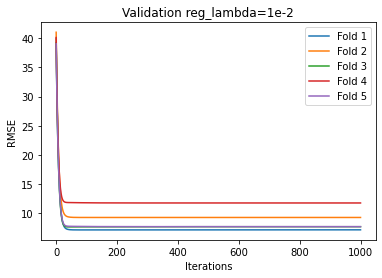

In [82]:
plot_RMSEs(all_valRMSEs, "Validation reg_lambda=1e-2", "Iterations", "RMSE")

In [83]:
all_trainRMSEs = []
all_valRMSEs = []
RMSEs = []
MSEs = []
for fold in five_folds:
    X_train, y_train, X_test, y_test = fold
    standard_scaler = StandardScaler()
    X_train = standard_scaler.fit_transform(X_train)
    X_test = standard_scaler.transform(X_test) 
    X_train = add_ones(X_train)
    X_test = add_ones(X_test)
    LR = LinearRegression(learning_rate=0.1, epochs=1000, early_stopping=True, regularization='Lasso', reg_lambda=1e-1)
    LR.fit(X_train, y_train, X_test, y_test)
    params = LR.get_params()
    all_trainRMSEs.append(LR.get_trainRMSEs())
    all_valRMSEs.append(LR.get_valRMSEs())
print()

<module 'matplotlib.pyplot' from 'C:\\Users\\ASUS\\AppData\\Local\\Packages\\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\\LocalCache\\local-packages\\Python39\\site-packages\\matplotlib\\pyplot.py'>

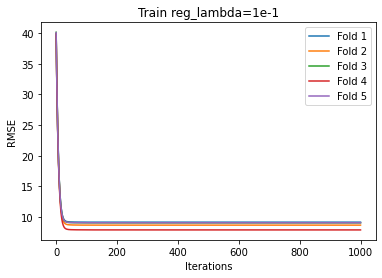

In [84]:
plot_RMSEs(all_trainRMSEs, "Train reg_lambda=1e-1", "Iterations", "RMSE")

<module 'matplotlib.pyplot' from 'C:\\Users\\ASUS\\AppData\\Local\\Packages\\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\\LocalCache\\local-packages\\Python39\\site-packages\\matplotlib\\pyplot.py'>

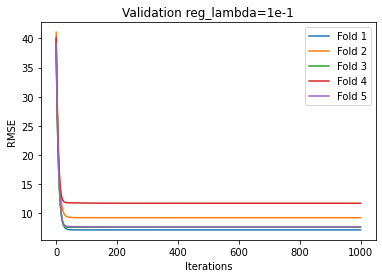

In [85]:
plot_RMSEs(all_valRMSEs, "Validation reg_lambda=1e-1", "Iterations", "RMSE")

In [86]:
all_trainRMSEs = []
all_valRMSEs = []
RMSEs = []
MSEs = []
for fold in five_folds:
    X_train, y_train, X_test, y_test = fold
    standard_scaler = StandardScaler()
    X_train = standard_scaler.fit_transform(X_train)
    X_test = standard_scaler.transform(X_test) 
    X_train = add_ones(X_train)
    X_test = add_ones(X_test)
    LR = LinearRegression(learning_rate=0.1, epochs=1000, early_stopping=True, regularization='Lasso', reg_lambda=1)
    LR.fit(X_train, y_train, X_test, y_test)
    params = LR.get_params()
    all_trainRMSEs.append(LR.get_trainRMSEs())
    all_valRMSEs.append(LR.get_valRMSEs())
print()

<module 'matplotlib.pyplot' from 'C:\\Users\\ASUS\\AppData\\Local\\Packages\\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\\LocalCache\\local-packages\\Python39\\site-packages\\matplotlib\\pyplot.py'>

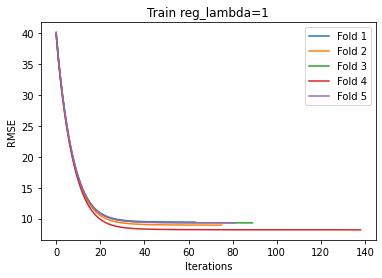

In [87]:
plot_RMSEs(all_trainRMSEs, "Train reg_lambda=1", "Iterations", "RMSE")

<module 'matplotlib.pyplot' from 'C:\\Users\\ASUS\\AppData\\Local\\Packages\\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\\LocalCache\\local-packages\\Python39\\site-packages\\matplotlib\\pyplot.py'>

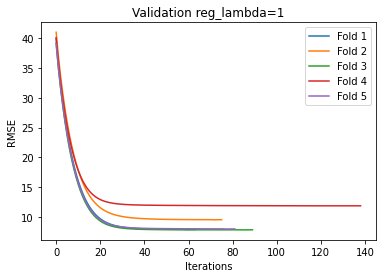

In [88]:
plot_RMSEs(all_valRMSEs, "Validation reg_lambda=1", "Iterations", "RMSE")

In [89]:
all_trainRMSEs = []
all_valRMSEs = []
RMSEs = []
MSEs = []
for fold in five_folds:
    X_train, y_train, X_test, y_test = fold
    standard_scaler = StandardScaler()
    X_train = standard_scaler.fit_transform(X_train)
    X_test = standard_scaler.transform(X_test) 
    X_train = add_ones(X_train)
    X_test = add_ones(X_test)
    LR = LinearRegression(learning_rate=0.1, epochs=1000, early_stopping=True, regularization='Lasso', reg_lambda=10)
    LR.fit(X_train, y_train, X_test, y_test)
    params = LR.get_params()
    all_trainRMSEs.append(LR.get_trainRMSEs())
    all_valRMSEs.append(LR.get_valRMSEs())
print()

<module 'matplotlib.pyplot' from 'C:\\Users\\ASUS\\AppData\\Local\\Packages\\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\\LocalCache\\local-packages\\Python39\\site-packages\\matplotlib\\pyplot.py'>

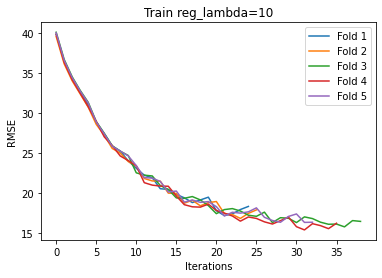

In [90]:
plot_RMSEs(all_trainRMSEs, "Train reg_lambda=10", "Iterations", "RMSE")

<module 'matplotlib.pyplot' from 'C:\\Users\\ASUS\\AppData\\Local\\Packages\\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\\LocalCache\\local-packages\\Python39\\site-packages\\matplotlib\\pyplot.py'>

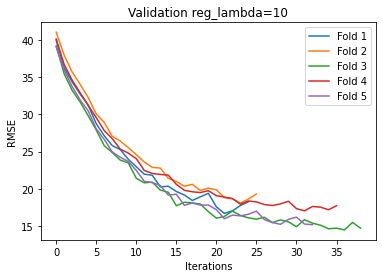

In [91]:
plot_RMSEs(all_valRMSEs, "Validation reg_lambda=10", "Iterations", "RMSE")

In [92]:
all_trainRMSEs = []
all_valRMSEs = []
RMSEs = []
MSEs = []
for fold in five_folds:
    X_train, y_train, X_test, y_test = fold
    standard_scaler = StandardScaler()
    X_train = standard_scaler.fit_transform(X_train)
    X_test = standard_scaler.transform(X_test) 
    X_train = add_ones(X_train)
    X_test = add_ones(X_test)
    LR = LinearRegression(learning_rate=0.1, epochs=1000, early_stopping=True, regularization='Lasso', reg_lambda=100)
    LR.fit(X_train, y_train, X_test, y_test)
    params = LR.get_params()
    all_trainRMSEs.append(LR.get_trainRMSEs())
    all_valRMSEs.append(LR.get_valRMSEs())
print()

<module 'matplotlib.pyplot' from 'C:\\Users\\ASUS\\AppData\\Local\\Packages\\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\\LocalCache\\local-packages\\Python39\\site-packages\\matplotlib\\pyplot.py'>

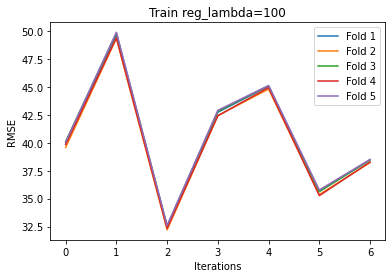

In [93]:
plot_RMSEs(all_trainRMSEs, "Train reg_lambda=100", "Iterations", "RMSE")

<module 'matplotlib.pyplot' from 'C:\\Users\\ASUS\\AppData\\Local\\Packages\\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\\LocalCache\\local-packages\\Python39\\site-packages\\matplotlib\\pyplot.py'>

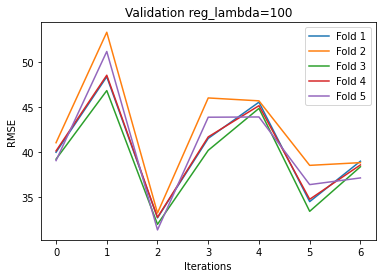

In [94]:
plot_RMSEs(all_valRMSEs, "Validation reg_lambda=100", "Iterations", "RMSE")

# Normal Form

In [95]:
RMSEs = []
MSEs = []
for i, fold in enumerate(five_folds):
    print("Fold", i+1)
    X_train, y_train, X_test, y_test = fold
    params = solveNormalEquation(X_train, y_train)
    rmse, mse = evaluate_model(X_test, y_test, params)
    RMSEs.append(rmse)
    MSEs.append(mse)
    print('RMSE: {}, MSE: {}'.format(rmse, mse))
print(f"Average RMSE: {np.mean(RMSEs)}, Average MSE: {np.mean(MSEs)}")

Fold 1
RMSE: 7.15465365030286, MSE: 51.18906885579204
Fold 2
RMSE: 9.266839756448137, MSE: 85.87431907168776
Fold 3
RMSE: 7.695705437572973, MSE: 59.22388218189022
Fold 4
RMSE: 11.724728270732339, MSE: 137.46925302251015
Fold 5
RMSE: 7.693396778376939, MSE: 59.18835398954066
Average RMSE: 8.707064778686648, Average MSE: 78.58897542428416
